In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Flow, FlowSubtraction
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold, SetStyle
SetStyle()


# Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [2]:
data_params = { "n_dim": 1,
                "n_mc": 100000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 100000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 10000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut": True ,
                "efficiency": 0.1,
                "acceptance": 0.1,
                "empty_value": -5.0,
}

In [3]:
ToyModel = GaussianToy(data_params)

# Define background subtraction flow

In [4]:
bkg_mc = ToyModel.mc_background_rec

In [5]:
flow_params = { "hidden_layers": 2,
               "internal_size": 64,
               "lr": 1.e-4,
               "n_epochs" : 100,
               "batch_size" : 128,
               "batch_size_sample": 2000}

In [6]:
background_generator = Flow(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params)

In [7]:
background_generator.train(bkg_mc,weights = torch.ones_like(bkg_mc[:,0]))

Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.8625301122665405 after time 0.8
    Finished epoch 20 with average loss 1.6186883449554443 after time 9.5
    Finished epoch 40 with average loss 1.615081548690796 after time 17.3
    Finished epoch 60 with average loss 1.6065462827682495 after time 25.2
    Finished epoch 80 with average loss 1.614582896232605 after time 33.1
    Finished epoch 99 with average loss 1.6077287197113037 after time 40.5


In [8]:
generated_background = background_generator.evaluate(num_evts = ToyModel.mc_background_rec.size(0))

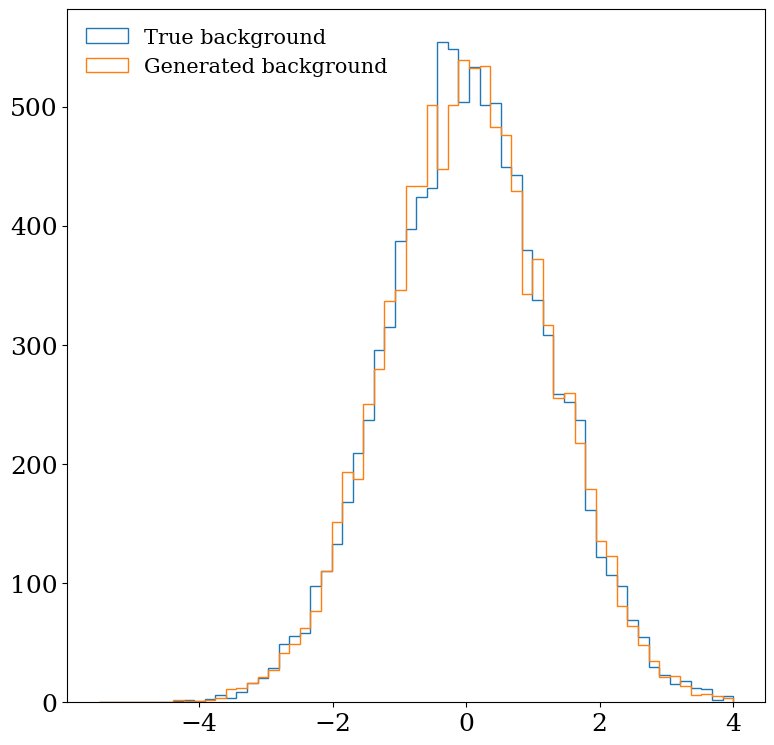

In [9]:
y_true = plt.hist(ToyModel.mc_background_rec[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "True background", histtype='step')
y_gen = plt.hist(generated_background[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "Generated background", histtype='step')
plt.legend()

In [10]:
if not os.path.exists("Plots"):
    os.makedirs("Plots")

with PdfPages(f"Plots/background_generated.pdf") as out:
    plot_reweighted_distribution(out, 
                                 ToyModel.mc_background_rec[:,0].cpu().detach().numpy(),
                                 generated_background[:,0].cpu().detach().numpy(),
                                 np.random.normal(0, 1.0, size=ToyModel.mc_background_rec[:,0].size(0)),
                                 range=[-3,4], labels=[r"true background" , "gaussian", "background generated",], name="x_1")    

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:194: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)


In [11]:
signal_generator = FlowSubtraction(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params,
                                   background_model = background_generator.network,
                                   bkg_fraction = data_params["n_background"]*1.0/(data_params["n_data"] +  data_params["n_background"]))

In [12]:
signal_generator.train(ToyModel.data_rec[ToyModel.data_rec_mask.bool()],weights = torch.ones_like(ToyModel.data_rec[ToyModel.data_rec_mask.bool()][:,0]))

Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.3957401514053345 after time 5.5
    Finished epoch 20 with average loss 1.3931790590286255 after time 114.2
    Finished epoch 40 with average loss 1.3931248188018799 after time 223.1
    Finished epoch 60 with average loss 1.3930439949035645 after time 331.0
    Finished epoch 80 with average loss 1.3930256366729736 after time 439.2
    Finished epoch 99 with average loss 1.3930027484893799 after time 543.3


# Generate the signal and generate empty events at reco level

In [13]:
num_data_reco = ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].size(0)
generated_signal = signal_generator.evaluate(num_evts = num_data_reco) #N*(1-delta)

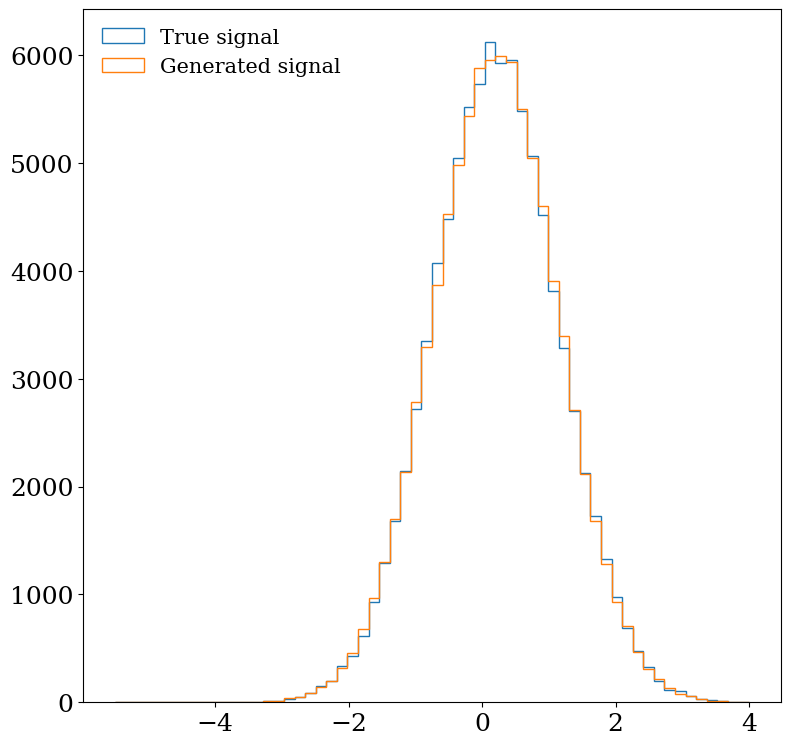

In [14]:
y_true = plt.hist(ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "True signal", histtype='step')
y_gen = plt.hist(generated_signal[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "Generated signal", histtype='step')
plt.legend()

In [15]:
num_data_empty = num_data_reco*data_params['acceptance']/(1.0 - data_params['acceptance']) #N*(1-delta)*epsilon/(1-epsilon)
#Add the empty events to the generated signals
generated_signal = torch.cat([generated_signal,data_params["empty_value"]*torch.ones_like(generated_signal[:int(num_data_empty)])])

In [16]:
print(f"Number of expected signal events in the data {generated_signal.size(0)}")

Number of expected signal events in the data 99963


# Train Acceptance classifier

In [17]:
acceptance_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [18]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [19]:
acceptance_classifier = Classifier(dims_in=1, params=acceptance_classifier_params)

In [20]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

    Training with unbalanced training set with weight 8.921229481106092
Training classifier for 240 epochs with lr 0.0001
    Finished epoch 0 with average loss 7.087390422821045 after time 0.3
    Finished epoch 48 with average loss 3.2423675060272217 after time 16.7
    Finished epoch 96 with average loss 3.2424774169921875 after time 33.2
    Finished epoch 144 with average loss 3.2424004077911377 after time 49.5
    Finished epoch 192 with average loss 3.242119312286377 after time 65.9
    Finished epoch 239 with average loss 3.2424426078796387 after time 81.9


# Train efficiency classifier

In [21]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [22]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]

In [23]:
efficiency_classifier = Classifier(dims_in = 1, params = efficiency_classifier_params)

In [24]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 9.010570824524313
Training classifier for 270 epochs with lr 0.0001
    Finished epoch 0 with average loss 6.895405292510986 after time 0.3
    Finished epoch 54 with average loss 3.251912832260132 after time 18.8
    Finished epoch 108 with average loss 3.2514965534210205 after time 37.2
    Finished epoch 162 with average loss 3.251687526702881 after time 55.5
    Finished epoch 216 with average loss 3.251861095428467 after time 73.9
    Finished epoch 269 with average loss 3.2513234615325928 after time 91.9


# Let's train the detector response flow p(reco|gen) and the initial p(gen) flows

In [25]:
gen_generator = Flow(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params)

In [26]:
gen_generator.train(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()],weights = torch.ones_like(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()][:,0]))

Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.4359397888183594 after time 3.9
    Finished epoch 20 with average loss 1.4203417301177979 after time 80.0
    Finished epoch 40 with average loss 1.4202640056610107 after time 154.0
    Finished epoch 60 with average loss 1.4201679229736328 after time 229.7
    Finished epoch 80 with average loss 1.420112133026123 after time 304.8
    Finished epoch 99 with average loss 1.4201326370239258 after time 375.2


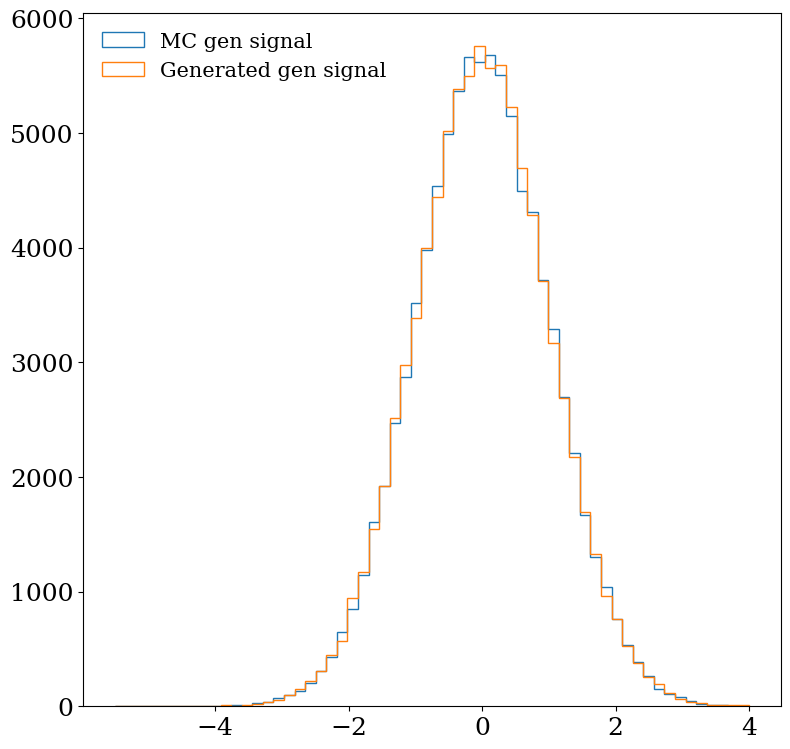

In [27]:
y_true = plt.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC gen signal", histtype='step')
y_gen = plt.hist(gen_generator.evaluate(num_evts = ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()].size(0)).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated gen signal", histtype='step')
plt.legend()

In [28]:
detector_generator = Flow(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = flow_params)

In [29]:
detector_generator.train(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()],
                         weights = torch.ones_like(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()][:,0]), 
                         data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()])

using conditional model
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.062523365020752 after time 4.3
    Finished epoch 20 with average loss 0.8094683289527893 after time 90.3
    Finished epoch 40 with average loss 0.808793306350708 after time 176.8
    Finished epoch 60 with average loss 0.8083740472793579 after time 264.9
    Finished epoch 80 with average loss 0.8077488541603088 after time 354.4
    Finished epoch 99 with average loss 0.8075146079063416 after time 438.2


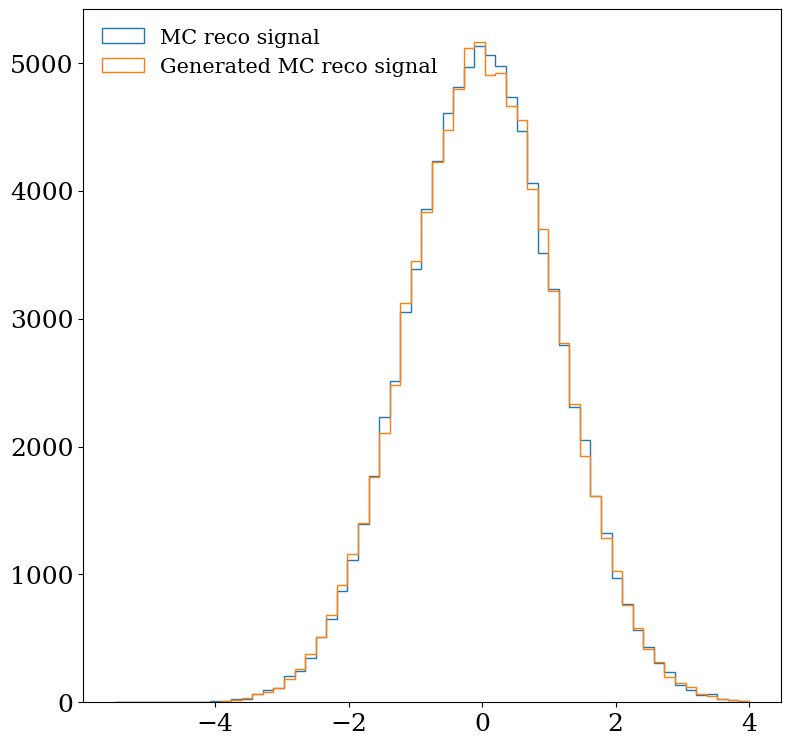

In [30]:
y_true = plt.hist(ToyModel.mc_rec[:,0][ToyModel.mc_rec_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC reco signal", histtype='step')
y_gen = plt.hist(detector_generator.evaluate(data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()]).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated MC reco signal", histtype='step')
plt.legend()

# Start the unfolding!

In [31]:
def sample_reco(nevts,empty_fraction, efficiency_classifier,detector_model,gen_model):
    ''' Generates h(reco|gen) samples by sampling from: h(reco|gen) = c(gen) + (1-c(gen))*p(reco|gen)*p(gen) '''
    gen_events = gen_model.evaluate(num_evts = nevts)
    gen_mask = ToyModel.apply_efficiency_acceptance_effects(gen_events,empty_fraction)
    gen_events[~gen_mask.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~gen_mask.bool()])
    
    efficiency = efficiency_classifier.evaluate(gen_events, return_weights=False)
    sample_efficiency = torch.bernoulli(efficiency)
    
    reco_events = detector_model.evaluate(data_c=gen_events)
    reco_events[~sample_efficiency.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~sample_efficiency.bool()])
    return  reco_events, gen_events, gen_mask 

Running iteration 0
using conditional model
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.9166903495788574 after time 4.5
    Finished epoch 20 with average loss 0.7036415934562683 after time 92.8
    Finished epoch 40 with average loss 0.7019829750061035 after time 180.0
    Finished epoch 60 with average loss 0.700752854347229 after time 267.6
    Finished epoch 80 with average loss 0.7000097632408142 after time 355.7
    Finished epoch 99 with average loss 0.6997593641281128 after time 437.2
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.308671236038208 after time 4.1
    Finished epoch 20 with average loss 1.3068369626998901 after time 85.3
    Finished epoch 40 with average loss 1.3067352771759033 after time 166.7
    Finished epoch 60 with average loss 1.3067439794540405 after time 247.6
    Finished epoch 80 with average loss 1.306665062904358 after time 328.9
    Finished epoch 

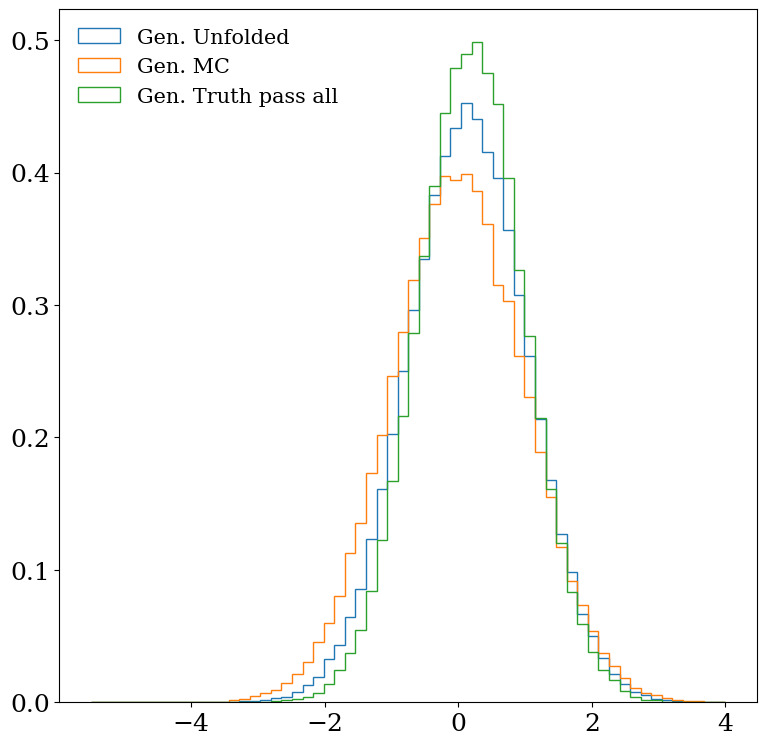

Running iteration 1
using conditional model
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6686062216758728 after time 4.1
    Finished epoch 20 with average loss 0.6677732467651367 after time 89.7
    Finished epoch 40 with average loss 0.666975736618042 after time 175.6
    Finished epoch 60 with average loss 0.6661808490753174 after time 261.1
    Finished epoch 80 with average loss 0.6657658219337463 after time 347.6
    Finished epoch 99 with average loss 0.6655614376068115 after time 429.0
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2549086809158325 after time 3.9
    Finished epoch 20 with average loss 1.2547608613967896 after time 85.1
    Finished epoch 40 with average loss 1.2547494173049927 after time 166.3
    Finished epoch 60 with average loss 1.2546476125717163 after time 247.3
    Finished epoch 80 with average loss 1.2545777559280396 after time 329.7
    Finished epoc

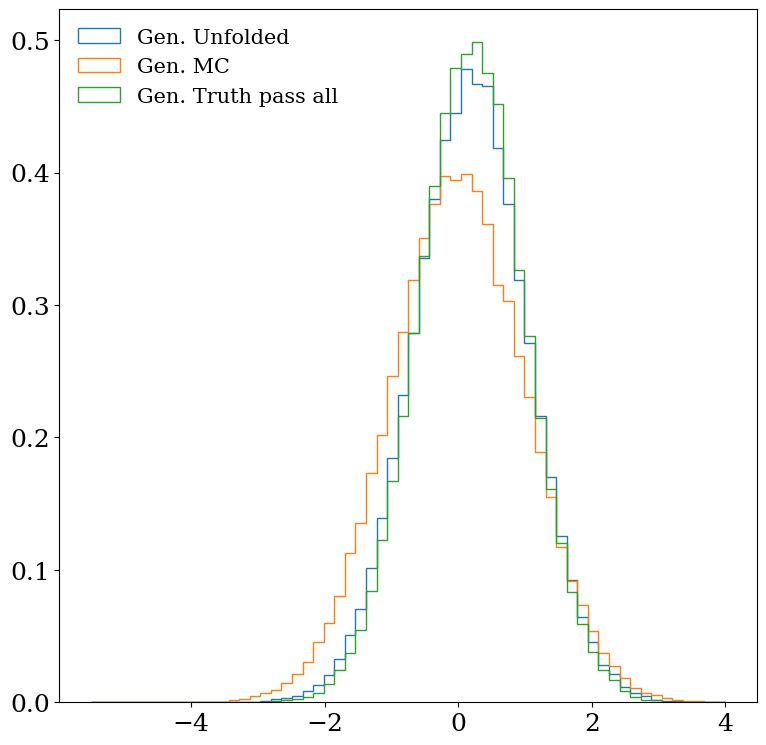

Running iteration 2
using conditional model
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6491259336471558 after time 4.3
    Finished epoch 20 with average loss 0.648750364780426 after time 90.4
    Finished epoch 40 with average loss 0.6483020186424255 after time 176.2
    Finished epoch 60 with average loss 0.6475183963775635 after time 265.6
    Finished epoch 80 with average loss 0.6471478343009949 after time 354.1
    Finished epoch 99 with average loss 0.6468883156776428 after time 435.8
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2287935018539429 after time 4.1
    Finished epoch 20 with average loss 1.228735327720642 after time 85.2
    Finished epoch 40 with average loss 1.2287009954452515 after time 169.5
    Finished epoch 60 with average loss 1.2286360263824463 after time 254.0
    Finished epoch 80 with average loss 1.2285592555999756 after time 336.1
    Finished epoch

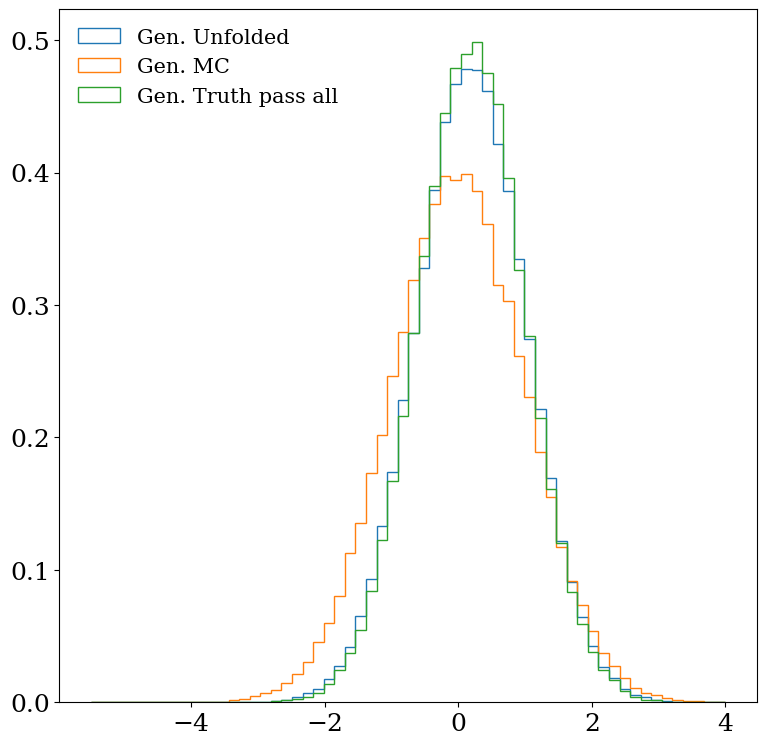

Running iteration 3
using conditional model
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6409472823143005 after time 4.2
    Finished epoch 20 with average loss 0.6402176022529602 after time 91.2
    Finished epoch 40 with average loss 0.6401461362838745 after time 176.9
    Finished epoch 60 with average loss 0.6392264366149902 after time 262.8
    Finished epoch 80 with average loss 0.6389085054397583 after time 348.8
    Finished epoch 99 with average loss 0.6390498876571655 after time 430.1
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.214078664779663 after time 4.1
    Finished epoch 20 with average loss 1.213964581489563 after time 85.0
    Finished epoch 40 with average loss 1.2139358520507812 after time 166.9
    Finished epoch 60 with average loss 1.213869333267212 after time 251.5
    Finished epoch 80 with average loss 1.2138022184371948 after time 336.2
    Finished epoch 

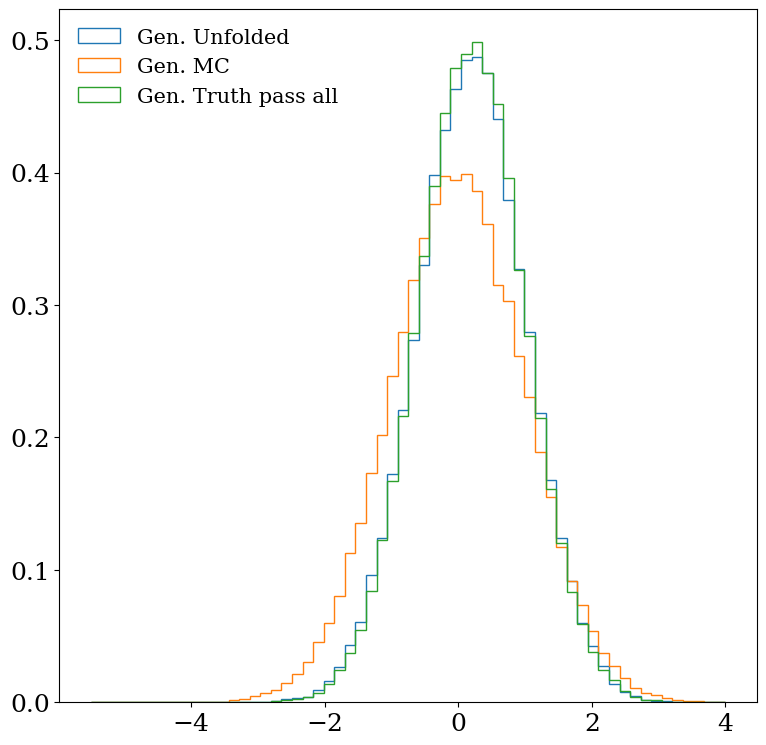

Running iteration 4
using conditional model
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6361703872680664 after time 4.3
    Finished epoch 20 with average loss 0.6357029676437378 after time 87.8
    Finished epoch 40 with average loss 0.6353914737701416 after time 173.1
    Finished epoch 60 with average loss 0.6348092555999756 after time 259.1
    Finished epoch 80 with average loss 0.6344091296195984 after time 343.0
    Finished epoch 99 with average loss 0.6342771649360657 after time 424.6
Training generative model for 100 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2123212814331055 after time 4.0
    Finished epoch 20 with average loss 1.2124412059783936 after time 85.1
    Finished epoch 40 with average loss 1.212382435798645 after time 167.3
    Finished epoch 60 with average loss 1.212306261062622 after time 249.7
    Finished epoch 80 with average loss 1.2122166156768799 after time 332.1
    Finished epoch

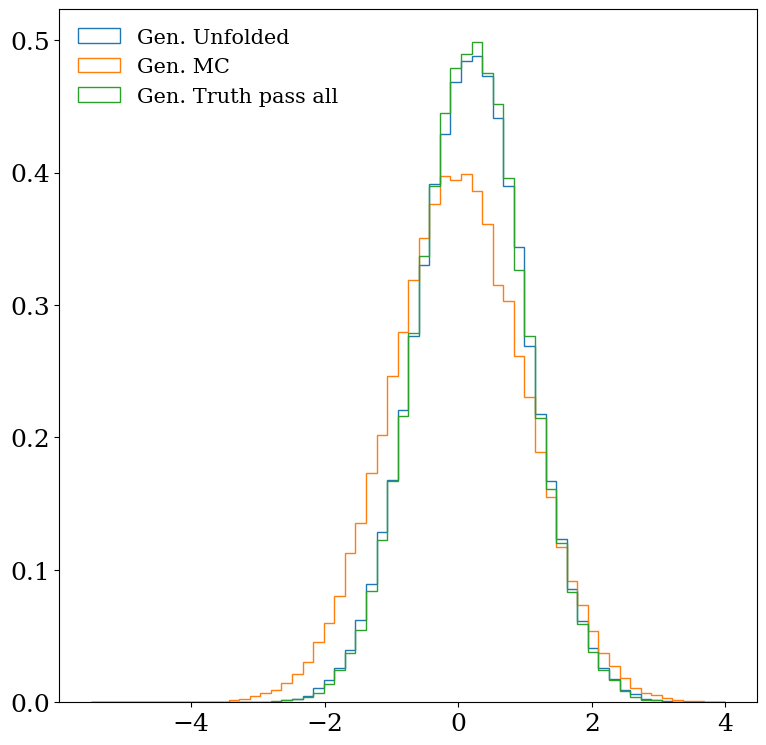

In [32]:
iterations = 5
unfold_generator =  Flow(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = flow_params)
for i in range(iterations):
    print(f"Running iteration {i}")
    reco_train, gen_train, gen_mask = sample_reco(data_params['n_mc'], 
                                                 data_params['efficiency'],
                                                 efficiency_classifier,
                                                 detector_generator,
                                                 gen_generator)
    unfold_generator.train(gen_train[gen_mask.bool()], 
                           weights = torch.ones_like(gen_train[gen_mask.bool()][:,0]), 
                           data_c = reco_train[gen_mask.bool()])
    unfolded = unfold_generator.evaluate(data_c=generated_signal)
    gen_generator.train(unfolded,weights = torch.ones_like(unfolded[:,0]))
    #FIXME: Probably need to update the efficiency classifier here
    fig, axes = plt.subplots()
    axes.hist(unfolded[:,0].cpu().detach().numpy(), bins=60, histtype="step", range=[-5.5,4],label="Gen. Unfolded",density=True)
    axes.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),bins=60, histtype='step', range=[-5.5,4],label="Gen. MC",density=True)
    axes.hist(ToyModel.data_gen[:,0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(), 
              bins=60, range=[-5.5,4], histtype="step", label="Gen. Truth pass all",density=True)
    plt.legend()  # Display the legend
    plt.show()

# Fix Acceptance with empty true events

In [33]:
acceptance = acceptance_classifier.evaluate(generated_signal, return_weights=False)
acceptance_mask = torch.bernoulli(acceptance)
unfolded = unfolded[acceptance_mask.bool()]
print(f"Unfolded true events {unfolded.size(0)}, Number of true data events {torch.sum(ToyModel.data_gen_mask.bool())}")

Unfolded true events 90128, Number of true data events 89871


In [34]:
with PdfPages(f"Plots/final_generative_unfolding.pdf") as out:
    plot_naive_unfold(out, 
                      ToyModel.data_gen[:, 0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(),
                      ToyModel.data_rec[:, 0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(),
                      unfolded[:, 0].cpu().detach().numpy(),
                      range=[-3, 4], name="x_1")

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:88: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:89: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:88: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
